## RNN

* So let's start by importing all required libraries

In [1]:
import numpy as np
import nltk
import re
from nltk import tokenize
from datetime import datetime
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import sys
import operator
import pickle

%matplotlib inline

* Let's set random seed for grtting reproducible (deterministic) results

In [2]:
np.random.seed(1)

* Now let's open shakespeare file and see what are the unique characters in it

In [3]:
with open("./data/shakespeare-sonnets.txt", "r") as f:
    print(set(f.read()))

{';', '8', 'c', 'q', 'z', 'K', 'e', '0', '2', 'J', 'V', 'a', 'n', 'u', '.', 'o', 'g', 'U', 'Y', 'A', 'y', 'G', ']', '\n', 'M', 'j', 'm', "'", 'F', 'W', 'I', 'E', 't', 'w', ',', '?', 'r', 'D', '-', '9', 'C', 'h', 'k', 'l', 'N', 'O', 'B', 'H', 'S', '5', '"', 'f', 'R', 'd', 'v', 'p', '7', '[', 'P', '1', 'b', 'i', ' ', ':', 'L', 's', '4', 'x', '!', '6', '3', 'T'}


* As you can see from above result that there are many unwanted characters that should be removed
* So now let's write a function to remove roman numerals

In [4]:
def clean_roman_numerals(text):
    pattern = r"\b(?=[MDCLXVIΙ])M{0,4}(CM|CD|D?C{0,3})(XC|XL|L?X{0,3})([IΙ]X|[IΙ]V|V?[IΙ]{0,3})\b\.?"
    return re.sub(pattern, "", text)

* Let's test this function

In [5]:
clean_roman_numerals("XI abcdefg")

' abcdefg'

* As you can see that the function is working as expected
* So now let's write a function to remove numerical numbers

In [6]:
def clean_numerical_numbers(text):
    # Remove numbers
    pattern = r'\d+'
    return re.sub(pattern, "", text)

* Let's test this function now

In [7]:
clean_numerical_numbers("1 abcdefg 1256")

' abcdefg '

* As you can see from above results that the function is working as expected
* Now let's write a function to remove spaces at start of sentence

In [8]:
def clean_spaces_at_start(text):
    return re.sub(r'^[ \t]+', '', text, flags=re.MULTILINE)

* Let's test thei function now

In [9]:
clean_spaces_at_start("    ananvbsbbs\n       shsbsnns")

'ananvbsbbs\nshsbsnns'

* As you can see the function is working as expected
* Now let's write a function to remove square brackets

In [10]:
def clean_square_brackets(text):
    return re.sub(r'\[\]', '', text, flags=re.MULTILINE)

* Now let's test this function

In [11]:
clean_square_brackets("[] abcdefg \n [] annsjsnn")

' abcdefg \n  annsjsnn'

* As you can see that the function is correct
* Shakespeare given corpus contains sonets (14 line poems)
* We are going to add `<SONET_START>` token and `<SONET_END>` token at start and end of these poems (sonets) respectively
* Adding these tokens will help our model to recognize these poem patterns
* Now let's write a function to add sonet tokens

In [12]:
def add_sonet_tokens(text):
    text = "<SONET_START> " + text[2:-1] + "<SONET_END>"
    return re.sub(r'\n\n\n\n', " <SONET_END>\n<SONET_START> ", text)

* Now let's write a function which preprocesses data by using above functions, generate vocabulary and also generate sentence tokens broke down in words

In [13]:
def tokenize_sentences(data_loc):
    print( "Reading txt file...")
    with open(f'{data_loc}', 'r') as f:
        text = f.read()
        text = clean_roman_numerals(text)
        text = clean_numerical_numbers(text)
        text = clean_square_brackets(text)
        text = clean_spaces_at_start(text)
        text = add_sonet_tokens(text)
        pattern = r'''<[^>]+>|\w+(?:'\w+)?|\n|[.,:;!?—()]'''
        tokens = re.findall(pattern, text)   
    # Count the word frequencies
    word_freq = nltk.FreqDist(token.lower() for token in tokens)
    print(f"Found {len(word_freq.items())} unique words tokens.")
    # Get the most common words and build index_to_word and word_to_index vectors
    vocabulary_size = len(word_freq.items())
    vocab = word_freq.most_common(vocabulary_size)
    index_to_word = [x[0] for x in vocab]
    # index_to_word.append(unknown_token)
    word_to_index = dict([(w,i) for i,w in enumerate(index_to_word)])
    print(f"The least frequent word in our vocabulary is '{vocab[-1][0]}' and appeared {vocab[-1][1]} times.")
    print(f"Using vocabulary size {vocabulary_size}.")
    return vocab, vocabulary_size, index_to_word, word_to_index, tokens

* Now let's apply above function on our shakespeare data

In [14]:
vocab, vocabulary_size, index_to_word, word_to_index, tokens = tokenize_sentences("./data/shakespeare-sonnets.txt")

Reading txt file...
Found 3195 unique words tokens.
The least frequent word in our vocabulary is 'smothered' and appeared 1 times.
Using vocabulary size 3195.


* As you can see that we are getting 3195 unique words and we are using all (i.e 3195) words as vocabulary size
* Let's print first 10 most common words from vocabulary

In [15]:
vocab[:10]

[('\n', 2184),
 (',', 1642),
 ('.', 554),
 ('and', 495),
 ('the', 436),
 ('to', 414),
 ('my', 375),
 ('of', 372),
 ('that', 329),
 ('in', 329)]

* Let's see size of vocabulary

In [16]:
vocabulary_size

3195

* Let's see first 10 words from index_to_word array

In [17]:
index_to_word[:10]

['\n', ',', '.', 'and', 'the', 'to', 'my', 'of', 'that', 'in']

* Now let's se word to index dictionary

In [18]:
word_to_index

{'\n': 0,
 ',': 1,
 '.': 2,
 'and': 3,
 'the': 4,
 'to': 5,
 'my': 6,
 'of': 7,
 'that': 8,
 'in': 9,
 'thy': 10,
 'thou': 11,
 ';': 12,
 'with': 13,
 'love': 14,
 'is': 15,
 'for': 16,
 'not': 17,
 'me': 18,
 'a': 19,
 'but': 20,
 'thee': 21,
 '<sonet_start>': 22,
 '<sonet_end>': 23,
 'be': 24,
 'so': 25,
 'as': 26,
 'all': 27,
 'you': 28,
 'his': 29,
 'which': 30,
 'when': 31,
 'this': 32,
 'it': 33,
 '?': 34,
 'by': 35,
 'your': 36,
 'doth': 37,
 'do': 38,
 'from': 39,
 'or': 40,
 'on': 41,
 'no': 42,
 'have': 43,
 'then': 44,
 'are': 45,
 'what': 46,
 'if': 47,
 'will': 48,
 'more': 49,
 'mine': 50,
 'their': 51,
 'shall': 52,
 'sweet': 53,
 'eyes': 54,
 'time': 55,
 'her': 56,
 'they': 57,
 'beauty': 58,
 'yet': 59,
 'nor': 60,
 'o': 61,
 'heart': 62,
 'art': 63,
 'than': 64,
 'now': 65,
 'fair': 66,
 'should': 67,
 'thine': 68,
 'one': 69,
 'can': 70,
 'make': 71,
 'he': 72,
 'hath': 73,
 'still': 74,
 'how': 75,
 'eye': 76,
 'she': 77,
 'him': 78,
 'true': 79,
 'where': 80,
 'li

* Let's see first 10 tokenized words

In [19]:
tokens[:10]

['<SONET_START>',
 'From',
 'fairest',
 'creatures',
 'we',
 'desire',
 'increase',
 ',',
 '\n',
 'That']

* To generate sequences of data to train and test on we are going to use n_grams
* So let's write a function which generates n sequence n-grams

In [20]:
def generate_sequences_n_grams(word_tokens, n):
    slices = [word_tokens[i:] for i in range(n)]
    return [list(i) for i in zip(*slices)]

* Now let's test this function
* Let's first test it with n_grams = 2

In [21]:
generate_sequences_n_grams(tokens, 2)[:10]

[['<SONET_START>', 'From'],
 ['From', 'fairest'],
 ['fairest', 'creatures'],
 ['creatures', 'we'],
 ['we', 'desire'],
 ['desire', 'increase'],
 ['increase', ','],
 [',', '\n'],
 ['\n', 'That'],
 ['That', 'thereby']]

* We are getting correct results
* Now let's also test it with n_grams = 3

In [22]:
generate_sequences_n_grams(tokens, 3)[:10]

[['<SONET_START>', 'From', 'fairest'],
 ['From', 'fairest', 'creatures'],
 ['fairest', 'creatures', 'we'],
 ['creatures', 'we', 'desire'],
 ['we', 'desire', 'increase'],
 ['desire', 'increase', ','],
 ['increase', ',', '\n'],
 [',', '\n', 'That'],
 ['\n', 'That', 'thereby'],
 ['That', 'thereby', "beauty's"]]

* As you can see that we are getting correct results
* Note that we are adding padding at start of an array instead of end
* Now let's write a function to generate feature and label data containing n_grams of length 2, 8, 16, 32 and 48 generated array having 10000 samples per n_gram
* Here we are creating data with different n_gram length because with n_gram = 2 model will be able to learn word mappings then with n_grams = 8 model will be able to learn relation ship between phrases then with n_gram = 16 model will be abe to learn relationship between sentences and with ngrams = 32 and 48 model will be able to learn relatonship between poems

In [23]:
def generate_data_n_grams(word_token, max_seq_len_per_n_gram=10000, n_grams=[2, 8, 16, 32, 48]):
    features_data = []
    target_data = []
    for current_n_gram in n_grams:
        n_gram_data = generate_sequences_n_grams(word_token, current_n_gram)
        selected_seuences = np.random.choice(len(n_gram_data), size=max_seq_len_per_n_gram)
        for sequence_number in selected_seuences:
            features_data.append(n_gram_data[sequence_number][:-1])
            target_data.append(n_gram_data[sequence_number][1:])
    return features_data, target_data

* Let's now generate data with above function

In [24]:
generated_features_data, generated_target_data = generate_data_n_grams(tokens)

* Let's see first 10  and last 10 generated features data

In [25]:
generated_features_data[:10], generated_features_data[-10:]

([['of'],
  ['<SONET_END>'],
  [','],
  ['deemed'],
  ['will'],
  ['living'],
  ['wish'],
  ['?'],
  ['besiege'],
  ['me']],
 [["war's",
   'quick',
   'fire',
   'shall',
   'burn',
   '\n',
   'The',
   'living',
   'record',
   'of',
   'your',
   'memory',
   '.',
   '\n',
   'Gainst',
   'death',
   'and',
   'all',
   'oblivious',
   'enmity',
   '\n',
   'Shall',
   'you',
   'pace',
   'forth',
   ';',
   'your',
   'praise',
   'shall',
   'still',
   'find',
   'room',
   '\n',
   'Even',
   'in',
   'the',
   'eyes',
   'of',
   'all',
   'posterity',
   '\n',
   'That',
   'wear',
   'this',
   'world',
   'out',
   'to'],
  ['thy',
   'love',
   ',',
   'and',
   'love',
   'that',
   'still',
   ',',
   '\n',
   'And',
   'then',
   'thou',
   'lovest',
   'me',
   ',',
   'for',
   'my',
   'name',
   'is',
   'Will',
   '.',
   '<SONET_END>',
   '\n',
   '<SONET_START>',
   'Thou',
   'blind',
   'fool',
   ',',
   'Love',
   ',',
   'what',
   'dost',
   'thou',
   'to

* Let's see first 10 and last 10 generated target data

In [26]:
generated_target_data[:10], generated_target_data[-10:]

([['mine'],
  ['\n'],
  ['\n'],
  ['\n'],
  ['give'],
  ['record'],
  [','],
  ['\n'],
  ['thy'],
  ['\n']],
 [['quick',
   'fire',
   'shall',
   'burn',
   '\n',
   'The',
   'living',
   'record',
   'of',
   'your',
   'memory',
   '.',
   '\n',
   'Gainst',
   'death',
   'and',
   'all',
   'oblivious',
   'enmity',
   '\n',
   'Shall',
   'you',
   'pace',
   'forth',
   ';',
   'your',
   'praise',
   'shall',
   'still',
   'find',
   'room',
   '\n',
   'Even',
   'in',
   'the',
   'eyes',
   'of',
   'all',
   'posterity',
   '\n',
   'That',
   'wear',
   'this',
   'world',
   'out',
   'to',
   'the'],
  ['love',
   ',',
   'and',
   'love',
   'that',
   'still',
   ',',
   '\n',
   'And',
   'then',
   'thou',
   'lovest',
   'me',
   ',',
   'for',
   'my',
   'name',
   'is',
   'Will',
   '.',
   '<SONET_END>',
   '\n',
   '<SONET_START>',
   'Thou',
   'blind',
   'fool',
   ',',
   'Love',
   ',',
   'what',
   'dost',
   'thou',
   'to',
   'mine',
   'eyes',
   

* As we already have vocabulary, now let's write a function to tokenize generated data

In [27]:
def tokenize_generated_data(data, word_to_index):
    tokenized_data = []
    for sequence in data:
        tokenized_data.append([word_to_index[i.lower()] for i in sequence])
    return tokenized_data

* Now let's tokenize features data

In [28]:
tokenized_features_data = tokenize_generated_data(generated_features_data, word_to_index)
len(tokenized_features_data)

50000

In [29]:
tokenized_features_data[:10], tokenized_features_data[-10:]

([[7], [23], [1], [1299], [48], [329], [466], [34], [899], [18]],
 [[2048,
   809,
   238,
   52,
   715,
   0,
   4,
   329,
   810,
   7,
   36,
   288,
   2,
   0,
   381,
   166,
   3,
   27,
   2049,
   2050,
   0,
   52,
   28,
   803,
   346,
   12,
   36,
   102,
   52,
   74,
   173,
   2051,
   0,
   116,
   9,
   4,
   54,
   7,
   27,
   658,
   0,
   8,
   699,
   32,
   101,
   159,
   5],
  [10,
   14,
   1,
   3,
   14,
   8,
   74,
   1,
   0,
   3,
   44,
   11,
   2995,
   18,
   1,
   16,
   6,
   161,
   15,
   48,
   2,
   23,
   0,
   22,
   11,
   405,
   820,
   1,
   14,
   1,
   46,
   94,
   11,
   5,
   50,
   54,
   0,
   8,
   57,
   333,
   3,
   83,
   17,
   46,
   57,
   83,
   34],
  [3,
   518,
   2660,
   872,
   21,
   6,
   113,
   7,
   14,
   2,
   0,
   65,
   27,
   15,
   482,
   1,
   43,
   46,
   52,
   43,
   42,
   230,
   2,
   0,
   50,
   812,
   162,
   49,
   48,
   2661,
   0,
   41,
   1318,
   873,
   1,
   5,
   2662,
   163,
 

* As you can see that we are getting correct tokenized features data
* Now let's do the same for target data

In [30]:
tokenized_target_data = tokenize_generated_data(generated_target_data, word_to_index)
len(tokenized_target_data)

50000

In [31]:
tokenized_target_data[:10], tokenized_target_data[-10:]

([[50], [0], [0], [0], [104], [810], [1], [0], [10], [0]],
 [[809,
   238,
   52,
   715,
   0,
   4,
   329,
   810,
   7,
   36,
   288,
   2,
   0,
   381,
   166,
   3,
   27,
   2049,
   2050,
   0,
   52,
   28,
   803,
   346,
   12,
   36,
   102,
   52,
   74,
   173,
   2051,
   0,
   116,
   9,
   4,
   54,
   7,
   27,
   658,
   0,
   8,
   699,
   32,
   101,
   159,
   5,
   4],
  [14,
   1,
   3,
   14,
   8,
   74,
   1,
   0,
   3,
   44,
   11,
   2995,
   18,
   1,
   16,
   6,
   161,
   15,
   48,
   2,
   23,
   0,
   22,
   11,
   405,
   820,
   1,
   14,
   1,
   46,
   94,
   11,
   5,
   50,
   54,
   0,
   8,
   57,
   333,
   3,
   83,
   17,
   46,
   57,
   83,
   34,
   0],
  [518,
   2660,
   872,
   21,
   6,
   113,
   7,
   14,
   2,
   0,
   65,
   27,
   15,
   482,
   1,
   43,
   46,
   52,
   43,
   42,
   230,
   2,
   0,
   50,
   812,
   162,
   49,
   48,
   2661,
   0,
   41,
   1318,
   873,
   1,
   5,
   2662,
   163,
   2663,
   188,
 

* As you can see that we are getting correct tokenized target data
* Now let's use glove embedding to embed this features token data

In [32]:
glove_dir = "./data/glove.6B.100d"

embeddings_index = {} #initialize dictionary
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding='utf8')
try:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
except:
    print(line)
f.close()

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


In [33]:
vocabulary_size

3195

In [34]:
embedding_dim = 100

embedding_matrix = np.zeros((vocabulary_size, embedding_dim))
for word, i in vocab:
    embedding_vector = embeddings_index.get(word)
    if i < vocabulary_size:
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [35]:
embedding_matrix.shape

(3195, 100)

In [36]:
vocab[4]

('the', 436)

In [37]:
embedding_matrix[4]

array([-0.24839   ,  0.41580001, -0.50120997, -0.46527001, -0.3831    ,
        0.46129   ,  0.37305999,  0.81476998, -0.6559    ,  0.094987  ,
        0.28314   , -0.79750001, -0.1247    ,  1.36459994,  0.11573   ,
       -0.60711998, -0.20911001, -0.20287   , -0.43491   ,  0.037515  ,
        0.054566  , -0.026389  , -0.39265001, -0.23852   , -0.29278001,
       -0.042224  , -0.39368001,  0.1583    , -0.64696997, -0.10887   ,
       -0.19221   ,  0.026955  , -0.39243999, -0.67449999, -0.24213   ,
        0.44674   , -0.31722999,  0.43742999, -0.32921001, -0.72364998,
        0.22341   , -0.46348   , -0.31382   , -1.59000003,  0.47584   ,
        0.84485   , -0.92957997,  0.2406    ,  1.09159994, -0.61738998,
        0.22025999, -0.08839   ,  0.20354   ,  0.43571001, -0.67427999,
       -2.23149991, -0.49112001, -0.54070997, -0.22719   , -0.011102  ,
        0.44363001,  0.17513999, -0.1183    ,  1.05610001,  0.73207003,
        0.77508003,  0.90759999, -0.59994   , -0.42039001, -0.84

* Now let's split the data into training and testing set

In [38]:
X_train, X_test, Y_train, Y_test = train_test_split(tokenized_features_data, tokenized_target_data, test_size=0.2)
len(X_train), len(X_test), len(Y_train), len(Y_test)

(40000, 10000, 40000, 10000)

In [39]:
X_train[:10]

[[1,
  5,
  913,
  728,
  41,
  21,
  2,
  0,
  59,
  54,
  32,
  729,
  577,
  5,
  235,
  51,
  63,
  98,
  0,
  57,
  717,
  20,
  46,
  57,
  83,
  1,
  136,
  17,
  4,
  62,
  2,
  23,
  0,
  22,
  107,
  86,
  95,
  45,
  9,
  730,
  13,
  51,
  459,
  0,
  7,
  578,
  335],
 [0, 31, 1730, 1731, 15, 17, 1732, 35, 125, 1, 0, 20, 112, 35, 125],
 [3,
  57,
  1357,
  218,
  0,
  109,
  88,
  95,
  1,
  17,
  424,
  66,
  1,
  42,
  58,
  593,
  1,
  0,
  2907,
  1292,
  13,
  19,
  129,
  1305,
  2,
  0,
  59,
  25,
  57,
  843,
  1,
  1358,
  7,
  51,
  221,
  1,
  0,
  8,
  123,
  160,
  415,
  58,
  67,
  122,
  25,
  2,
  23],
 [9, 29, 568, 1, 0, 31, 9],
 [1, 0, 30, 15, 17, 2880, 13, 2881, 1, 232, 42, 63, 0, 20, 944],
 [124, 884, 6, 1387, 5, 24, 19, 1388, 1, 0, 1389, 29, 1390, 13, 56],
 [606, 2, 23, 0, 22, 26, 19],
 [0,
  3,
  25,
  6,
  2411,
  272,
  253,
  15,
  2412,
  2,
  0,
  10,
  121,
  11,
  725,
  1,
  10,
  89,
  134,
  44,
  17,
  636,
  1,
  0,
  40,
  18,
  1,
  5,

In [40]:
Y_train[:10]

[[5,
  913,
  728,
  41,
  21,
  2,
  0,
  59,
  54,
  32,
  729,
  577,
  5,
  235,
  51,
  63,
  98,
  0,
  57,
  717,
  20,
  46,
  57,
  83,
  1,
  136,
  17,
  4,
  62,
  2,
  23,
  0,
  22,
  107,
  86,
  95,
  45,
  9,
  730,
  13,
  51,
  459,
  0,
  7,
  578,
  335,
  3],
 [31, 1730, 1731, 15, 17, 1732, 35, 125, 1, 0, 20, 112, 35, 125, 3],
 [57,
  1357,
  218,
  0,
  109,
  88,
  95,
  1,
  17,
  424,
  66,
  1,
  42,
  58,
  593,
  1,
  0,
  2907,
  1292,
  13,
  19,
  129,
  1305,
  2,
  0,
  59,
  25,
  57,
  843,
  1,
  1358,
  7,
  51,
  221,
  1,
  0,
  8,
  123,
  160,
  415,
  58,
  67,
  122,
  25,
  2,
  23,
  0],
 [29, 568, 1, 0, 31, 9, 386],
 [0, 30, 15, 17, 2880, 13, 2881, 1, 232, 42, 63, 0, 20, 944, 1354],
 [884, 6, 1387, 5, 24, 19, 1388, 1, 0, 1389, 29, 1390, 13, 56, 66],
 [2, 23, 0, 22, 26, 19, 1848],
 [3,
  25,
  6,
  2411,
  272,
  253,
  15,
  2412,
  2,
  0,
  10,
  121,
  11,
  725,
  1,
  10,
  89,
  134,
  44,
  17,
  636,
  1,
  0,
  40,
  18,
  1,
  5,

In [41]:
X_test[:10]

[[10,
  294,
  411,
  0,
  2314,
  4,
  2315,
  7,
  19,
  2316,
  256,
  12,
  0,
  59,
  46,
  7,
  21,
  10,
  991,
  37,
  1109,
  0,
  72,
  1104,
  21,
  7,
  3,
  1256,
  33,
  21,
  253],
 [12, 0, 25, 3062, 11, 254, 8],
 [390, 415, 77, 17, 77, 15, 3010],
 [1],
 [42, 49, 52, 368, 1, 0, 315],
 [3],
 [0],
 [178,
  18,
  87,
  1373,
  168,
  1,
  0,
  3190,
  9,
  4,
  361,
  129,
  3191,
  2,
  0,
  117,
  885,
  634,
  8,
  77,
  821,
  18,
  396,
  1,
  0,
  263,
  136,
  6,
  612,
  24,
  252,
  4,
  113,
  1,
  0,
  1,
  1351,
  1,
  1374,
  56,
  129,
  400,
  160,
  1,
  0,
  3192,
  262],
 [62],
 [0,
  59,
  38,
  17,
  25,
  12,
  20,
  114,
  82,
  519,
  1022,
  1,
  0,
  508,
  18,
  3017,
  13,
  209,
  1,
  3,
  3018,
  6,
  505,
  2,
  23,
  0,
  22,
  24,
  1232,
  26,
  11]]

In [42]:
Y_test[:10]

[[294,
  411,
  0,
  2314,
  4,
  2315,
  7,
  19,
  2316,
  256,
  12,
  0,
  59,
  46,
  7,
  21,
  10,
  991,
  37,
  1109,
  0,
  72,
  1104,
  21,
  7,
  3,
  1256,
  33,
  21,
  253,
  2],
 [0, 25, 3062, 11, 254, 8, 30],
 [415, 77, 17, 77, 15, 3010, 34],
 [3],
 [49, 52, 368, 1, 0, 315, 1],
 [308],
 [22],
 [18,
  87,
  1373,
  168,
  1,
  0,
  3190,
  9,
  4,
  361,
  129,
  3191,
  2,
  0,
  117,
  885,
  634,
  8,
  77,
  821,
  18,
  396,
  1,
  0,
  263,
  136,
  6,
  612,
  24,
  252,
  4,
  113,
  1,
  0,
  1,
  1351,
  1,
  1374,
  56,
  129,
  400,
  160,
  1,
  0,
  3192,
  262,
  9],
 [107],
 [59,
  38,
  17,
  25,
  12,
  20,
  114,
  82,
  519,
  1022,
  1,
  0,
  508,
  18,
  3017,
  13,
  209,
  1,
  3,
  3018,
  6,
  505,
  2,
  23,
  0,
  22,
  24,
  1232,
  26,
  11,
  63]]

* Now that we have splitted our data now let's write custom RNN with single layer which uses glove embedding

In [43]:
class RNN:    
    def __init__(self, word_dim, hidden_dim=100, bptt_truncate=4):
        self.word_dim = word_dim
        self.hidden_dim = hidden_dim
        self.bptt_truncate = bptt_truncate
        self.U = np.random.uniform(-np.sqrt(1./word_dim), np.sqrt(1./word_dim), (hidden_dim, embedding_dim))
        self.W = np.random.uniform(-np.sqrt(1./hidden_dim), np.sqrt(1./hidden_dim), (hidden_dim, hidden_dim))
        self.V = np.random.uniform(-np.sqrt(1./hidden_dim), np.sqrt(1./hidden_dim), (word_dim, hidden_dim))
        self.G = embedding_matrix

    def forward_propagation(self, x):
        # The total number of time steps
        T = len(x)
        # During forward propagation we save all hidden states in s because need them later.
        # We add one additional element for the initial hidden, which we set to 0
        s = np.zeros((T + 1, self.hidden_dim))
        s[-1] = np.zeros(self.hidden_dim)
        # The outputs at each time step. Again, we save them for later.
        o = np.zeros((T, self.word_dim))
        # For each time step...
        for t in np.arange(T):
            # embedding of x[t]:
            e_t = self.G[x[t]]                   
            # Note that we are indxing U by x[t]. This is the same as multiplying U with a one-hot vector.
            #s[t] = np.tanh(self.U[:,x[t]] + self.W.dot(s[t-1]))
            s[t] = np.tanh(self.U.dot(e_t) + self.W.dot(s[t-1]))
            o[t] = softmax(self.V.dot(s[t]))
        return [o, s]

    def predict(self, x):
        # Perform forward propagation and return index of the highest score
        o, s = self.forward_propagation(x)
        return np.argmax(o, axis=1)

    def calculate_total_loss(self, x, y):
        L = 0
        # For each sentence...
        for i in np.arange(len(y)):
            o, s = self.forward_propagation(x[i])
            # We only care about our prediction of the "correct" words
            correct_word_predictions = o[np.arange(len(y[i])), y[i]]
            # Add to the loss based on how off we were
            L += -1 * np.sum(np.log(correct_word_predictions))
        return L

    def calculate_loss(self, x, y):
        # Divide the total loss by the number of training examples
        N = np.sum((len(y_i) for y_i in y))
        return self.calculate_total_loss(x,y)/N

    def bptt(self, x, y):
        T = len(y)
        # Perform forward propagation
        o, s = self.forward_propagation(x)
        # We accumulate the gradients in these variables
        dLdU = np.zeros(self.U.shape)
        dLdV = np.zeros(self.V.shape)
        dLdW = np.zeros(self.W.shape)
        delta_o = o
        delta_o[np.arange(len(y)), y] -= 1.
        # For each output backwards...
        for t in np.arange(T)[::-1]:
            dLdV += np.outer(delta_o[t], s[t].T)
            # Initial delta calculation
            delta_t = self.V.T.dot(delta_o[t]) * (1 - (s[t] ** 2))
            # Backpropagation through time (for at most self.bptt_truncate steps)
            for bptt_step in np.arange(max(0, t-self.bptt_truncate), t+1)[::-1]:
                # print "Backpropagation step t=%d bptt step=%d " % (t, bptt_step)
                dLdW += np.outer(delta_t, s[bptt_step-1])              
                #dLdU[:,x[bptt_step]] += delta_t
                dLdU += np.outer(delta_t, self.G[x[bptt_step]]) 
                # Update delta for next step
                delta_t = self.W.T.dot(delta_t) * (1 - s[bptt_step-1] ** 2)
        return [dLdU, dLdV, dLdW]

    def gradient_check(self, x, y, h=0.001, error_threshold=0.01):
        # Calculate the gradients using backpropagation. We want to checker if these are correct.
        bptt_gradients = model.bptt(x, y)
        # List of all parameters we want to check.
        model_parameters = ['U', 'V', 'W']
        # Gradient check for each parameter
        for pidx, pname in enumerate(model_parameters):
            # Get the actual parameter value from the mode, e.g. model.W
            parameter = operator.attrgetter(pname)(self)
            print("Performing gradient check for parameter %s with size %d." % (pname, np.prod(parameter.shape)))     
            # Iterate over each element of the parameter matrix, e.g. (0,0), (0,1), ...
            it = np.nditer(parameter, flags=['multi_index'], op_flags=['readwrite'])
            while not it.finished:
                ix = it.multi_index   
                # Save the original value so we can reset it later
                original_value = parameter[ix]   
                # Estimate the gradient using (f(x+h) - f(x-h))/(2*h)
                parameter[ix] = original_value + h
                gradplus = model.calculate_total_loss([x],[y])
                parameter[ix] = original_value - h
                gradminus = model.calculate_total_loss([x],[y])
                estimated_gradient = (gradplus - gradminus)/(2*h)    
                # Reset parameter to original value
                parameter[ix] = original_value  
                # The gradient for this parameter calculated using backpropagation
                backprop_gradient = bptt_gradients[pidx][ix] 
                # calculate The relative error: (|x - y|/(|x| + |y|))
                relative_error = np.abs(backprop_gradient - estimated_gradient) / (
                                    np.abs(backprop_gradient) + np.abs(estimated_gradient))
                   # If the error is to large fail the gradient check
                if relative_error > error_threshold:
                    print( "Gradient Check ERROR: parameter=%s ix=%s" % (pname, ix))
                    print( "+h Loss: %f" % gradplus)
                    print( "-h Loss: %f" % gradminus)
                    print( "Estimated_gradient: %f" % estimated_gradient)
                    print( "Backpropagation gradient: %f" % backprop_gradient)
                    print( "Relative Error: %f" % relative_error)
                    return 
                it.iternext()     
            print( "Gradient check for parameter %s passed." % (pname))

    def sgd_step(self, x, y, learning_rate):
        # Calculate the gradients
        dLdU, dLdV, dLdW = self.bptt(x, y)
        
        # Change parameters according to gradients and learning rate
        self.U -= learning_rate * dLdU
        self.V -= learning_rate * dLdV
        self.W -= learning_rate * dLdW

* Let's write a softmax activation function code

In [44]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    # sometimes, may want to do this first:
    #x = np.vectorize(round)(x)
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

* Let's test written model for one sample in dataset

In [45]:
model = RNN(vocabulary_size)
o, s = model.forward_propagation(X_train[10000])

In [46]:
print (o.shape, o)

(7, 3195) [[0.00031299 0.00031299 0.00031299 ... 0.00031299 0.00031299 0.00031299]
 [0.00032618 0.00031194 0.00029823 ... 0.00029698 0.00031307 0.00031164]
 [0.00030632 0.00031649 0.00030686 ... 0.00030714 0.00031204 0.0003208 ]
 ...
 [0.00031068 0.00032478 0.0003044  ... 0.00032265 0.00031396 0.00031794]
 [0.0003034  0.00032446 0.00030852 ... 0.00031352 0.00031806 0.00032889]
 [0.00033368 0.00032757 0.00032311 ... 0.00032843 0.00032218 0.00031164]]


In [47]:
index_to_word[int(np.argmax(o[-1], axis=0))]

'birds'

* As you can see that the output is generated as expected
* Now let's see if model's prediction is equal to random predictions as model is not trained yet

In [48]:
print ("Expected Loss for random predictions: %f" % np.log(vocabulary_size))
print ("Actual loss: %f" % model.calculate_loss(X_train[:1000], Y_train[:1000]))

Expected Loss for random predictions: 8.069342


/tmp/ipykernel_14176/1748315108.py:48: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  N = np.sum((len(y_i) for y_i in y))


Actual loss: 8.068450


* As you can see that they are similar and our model is correct
* Let's also check model by doing gradient check which will check our backpropogation implementation is correct or not

In [49]:
grad_check_vocab_size = 100
np.random.seed(10)
model = RNN(grad_check_vocab_size, 10, bptt_truncate=1000)
model.gradient_check([0,1,2,3], [1,2,3,4])

Performing gradient check for parameter U with size 1000.
Gradient check for parameter U passed.
Performing gradient check for parameter V with size 1000.
Gradient check for parameter V passed.
Performing gradient check for parameter W with size 100.
Gradient check for parameter W passed.


* Now let's write a function for training model using stochastic gradient decent algorithm

In [50]:
def train_with_sgd(model, X_train, y_train, learning_rate=0.005, nepoch=100, evaluate_loss_after=5, validation_data=None):
    # We keep track of the losses so we can plot them later
    losses = []
    num_examples_seen = 0
    for epoch in range(nepoch):
        # Optionally evaluate the loss
        if (epoch % evaluate_loss_after == 0):
            loss = model.calculate_loss(X_train, y_train)
            if validation_data:
                val_loss = model.calculate_loss(validation_data[0], validation_data[1])
                losses.append((num_examples_seen, loss, val_loss))
                time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                print (f"{time}: Loss after num_examples_seen={num_examples_seen} epoch={epoch}: Training - {loss}  Testing - {val_loss}")
            else:
                losses.append((num_examples_seen, loss))
                time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                print (f"{time}: Loss after num_examples_seen={num_examples_seen} epoch={epoch}: {loss}")
            # Adjust the learning rate if loss increases
            if (len(losses) > 1 and losses[-1][1] > losses[-2][1]):
                learning_rate = learning_rate * 0.5  
                print (f"Setting learning rate to {learning_rate}")
            sys.stdout.flush()
        # For each training example...
        for i in range(len(y_train)):
            # One SGD step
            model.sgd_step(X_train[i], y_train[i], learning_rate)
            num_examples_seen += 1
    return losses

* Now let's train model on 50 epochs first

In [51]:
model = RNN(vocabulary_size)
losses = train_with_sgd(model, X_train, Y_train, nepoch=50, evaluate_loss_after=1, validation_data=(X_test, Y_test))

/tmp/ipykernel_14176/1748315108.py:48: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  N = np.sum((len(y_i) for y_i in y))


2025-11-02 01:03:30: Loss after num_examples_seen=0 epoch=0: Training - 8.06890918113278  Testing - 8.068799183842096
2025-11-02 01:12:22: Loss after num_examples_seen=40000 epoch=1: Training - 3.9312908122854484  Testing - 3.9894089560439787
2025-11-02 01:21:18: Loss after num_examples_seen=80000 epoch=2: Training - 3.433425034186288  Testing - 3.491797464779423
2025-11-02 01:29:55: Loss after num_examples_seen=120000 epoch=3: Training - 3.296033095089618  Testing - 3.354550309528791
2025-11-02 01:38:33: Loss after num_examples_seen=160000 epoch=4: Training - 3.296267204255384  Testing - 3.3514713273130767
Setting learning rate to 0.0025
2025-11-02 01:47:12: Loss after num_examples_seen=200000 epoch=5: Training - 2.9181946229283517  Testing - 2.97943247377824
2025-11-02 01:55:49: Loss after num_examples_seen=240000 epoch=6: Training - 2.854960863256655  Testing - 2.9164611647447325
2025-11-02 01:04:29: Loss after num_examples_seen=280000 epoch=7: Training - 2.8053729800011813  Testing

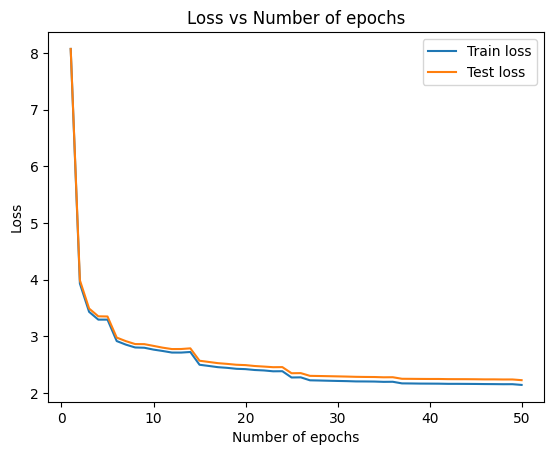

In [52]:
no_epochs = range(1, 51)
plt.plot(no_epochs, [loss[1] for loss in losses], label="Train loss")
plt.plot(no_epochs, [loss[2] for loss in losses], label="Test loss")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("Loss vs Number of epochs")
plt.legend()

* Now let's first save the weights of our model
  

In [53]:
with open('./weights/U.pkl', 'wb') as file:    
    pickle.dump(model.U, file)
with open('./weights/W.pkl', 'wb') as file:    
    pickle.dump(model.W, file)
with open('./weights/V.pkl', 'wb') as file:    
    pickle.dump(model.V, file)
with open('./weights/G.pkl', 'wb') as file:    
    pickle.dump(model.G, file)
    
with open('./weights/word_dim.pkl', 'wb') as file:    
    pickle.dump(model.word_dim, file)
with open('./weights/hidden_dim.pkl', 'wb') as file:    
    pickle.dump(model.hidden_dim, file)
with open('./weights/bptt_truncate.pkl', 'wb') as file:    
    pickle.dump(model.bptt_truncate, file)

* Now let's write a function to generate poem

In [54]:
def generate_poem(start_sent, length=0):
    start_sent = clean_roman_numerals(start_sent)
    start_sent = clean_numerical_numbers(start_sent)
    start_sent = clean_square_brackets(start_sent)
    start_sent = clean_spaces_at_start(start_sent)
    # start_sent = add_sonet_tokens(start_sent)
    pattern = r'''<[^>]+>|\w+(?:'\w+)?|\n|[.,:;!?—()]'''
    tokens = re.findall(pattern, start_sent)
    starting_sent = [tokens]
    tokenized_starting_sent = tokenize_generated_data(starting_sent, word_to_index)
    generated_poem = [tokens[0]]
    for i in tokens[1:]:
        if (i != "<sonet_start>" and i != "<sonet_end>"):
            if i not in ".,?;!\n":
                generated_poem.append(" ")
            generated_poem.append(i)
    if length:
        for i in range(length):
            next_pred_word = int(np.argmax(model.forward_propagation(tokenized_starting_sent[0])[0][-1], axis=0))
            if index_to_word[next_pred_word] != "<sonet_end>" and index_to_word[next_pred_word] != "<sonet_start>":
                if index_to_word[next_pred_word] not in ".,?;!\n" and generated_poem[-1] != "\n":
                    generated_poem.append(" ")
                generated_poem.append(index_to_word[next_pred_word])
            tokenized_starting_sent[0].append(next_pred_word)
    else:
        next_pred_word = "<sonet_start>"
        while next_pred_word != word_to_index["<sonet_end>"]:
            next_pred_word = int(np.argmax(model.forward_propagation(tokenized_starting_sent[0])[0][-1], axis=0))
            if index_to_word[next_pred_word] != "<sonet_end>" and index_to_word[next_pred_word] != "<sonet_start>":
                if index_to_word[next_pred_word] not in ".,?;!\n" and generated_poem[-1] != "\n":
                    generated_poem.append(" ")
                generated_poem.append(index_to_word[next_pred_word])
            tokenized_starting_sent[0].append(next_pred_word)
    return generated_poem

* Let's test this function by generating poem

In [55]:
print("".join(generate_poem("The", 100)))

The world of thy husbandry?
who, why, fearing friend, found for it is hate fair,
these the object burden should the pebbled shore.
pity this abundant issue seemed to me
or wrong them
hath impart as your sweet self resemble,
but with the day they on the pebbled,
summer's hath choirs, even for their eyes were, and look must
;
yet both with a bastard shame,
and age in love loves not to have years told.
therefore ll


* As you can see from above that our model is still improving (i.e loss is reducing) so let's do another 50 epochs of training

In [56]:
losses_next_50 = train_with_sgd(model, X_train, Y_train, nepoch=50, evaluate_loss_after=1, validation_data=(X_test, Y_test), learning_rate=7.8125e-05)

/tmp/ipykernel_14176/1748315108.py:48: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  N = np.sum((len(y_i) for y_i in y))


2025-11-02 07:21:54: Loss after num_examples_seen=0 epoch=0: Training - 2.1442368578981013  Testing - 2.2278772079124334
2025-11-02 07:30:57: Loss after num_examples_seen=40000 epoch=1: Training - 2.143395833586676  Testing - 2.2273594649309865
2025-11-02 07:39:53: Loss after num_examples_seen=80000 epoch=2: Training - 2.1429928624361163  Testing - 2.227803468490943
2025-11-02 07:48:51: Loss after num_examples_seen=120000 epoch=3: Training - 2.1419507007768304  Testing - 2.226448777196625
2025-11-02 07:57:56: Loss after num_examples_seen=160000 epoch=4: Training - 2.1414492926995607  Testing - 2.225720194751631
2025-11-02 08:07:26: Loss after num_examples_seen=200000 epoch=5: Training - 2.140418157192288  Testing - 2.2259688678285388
2025-11-02 08:18:22: Loss after num_examples_seen=240000 epoch=6: Training - 2.1397371525651145  Testing - 2.2250210769752825
2025-11-02 08:29:12: Loss after num_examples_seen=280000 epoch=7: Training - 2.1398960675387166  Testing - 2.2248821320616767
Sett

* Now let's plot the losses combined

In [60]:
losses_combined = losses + losses_next_50
len(losses_combined)

100

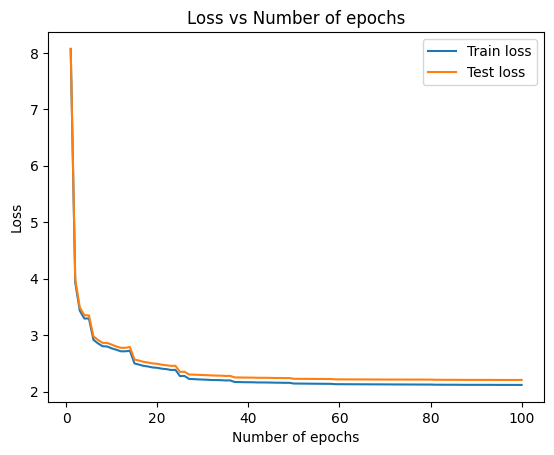

In [61]:
no_epochs = range(1, 101)
plt.plot(no_epochs, [loss[1] for loss in losses_combined], label="Train loss")
plt.plot(no_epochs, [loss[2] for loss in losses_combined], label="Test loss")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("Loss vs Number of epochs")
plt.legend()

* As you can see that there is no overfitting yer and model is improving but very slowly
* Let's first save weights

In [62]:
with open('./weights/U.pkl', 'wb') as file:    
    pickle.dump(model.U, file)
with open('./weights/W.pkl', 'wb') as file:    
    pickle.dump(model.W, file)
with open('./weights/V.pkl', 'wb') as file:    
    pickle.dump(model.V, file)
with open('./weights/G.pkl', 'wb') as file:    
    pickle.dump(model.G, file)
    
with open('./weights/word_dim.pkl', 'wb') as file:    
    pickle.dump(model.word_dim, file)
with open('./weights/hidden_dim.pkl', 'wb') as file:    
    pickle.dump(model.hidden_dim, file)
with open('./weights/bptt_truncate.pkl', 'wb') as file:    
    pickle.dump(model.bptt_truncate, file)

* Let's again generate a poem with updated model

In [63]:
print("".join(generate_poem("The", 100)))

The world of thy husbandry?
who, why, fearing friend, found for it is hate fair,
these is contented thy heart drudge should the sun,
and it that mine eye loves,
and, frantic mad, to die thou gav'st the glowing of laws,
though absence seemed, blunt so as foes commend,
but those same tongues hours wail night as any enjoyer,
applying on and cheeks,
not once vouchsafe thee;
then can drown best that thou mayst it thou spend


* As you can see that poem is better generated now compared to first model trained on just 50 epochs
* Let's train it on another 50 epochs

In [64]:
losses_next_50 = train_with_sgd(model, X_train, Y_train, nepoch=50, evaluate_loss_after=1, validation_data=(X_test, Y_test), learning_rate=4.8828125e-06)

/tmp/ipykernel_14176/1748315108.py:48: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  N = np.sum((len(y_i) for y_i in y))


2025-11-02 15:38:17: Loss after num_examples_seen=0 epoch=0: Training - 2.12019894922026  Testing - 2.208031997762855
2025-11-02 15:47:23: Loss after num_examples_seen=40000 epoch=1: Training - 2.120144668092074  Testing - 2.2079974168177627
2025-11-02 15:57:22: Loss after num_examples_seen=80000 epoch=2: Training - 2.1201973051278564  Testing - 2.2079861600439954
Setting learning rate to 2.44140625e-06
2025-11-02 16:06:50: Loss after num_examples_seen=120000 epoch=3: Training - 2.1199325365704413  Testing - 2.207880923146609
2025-11-02 16:15:50: Loss after num_examples_seen=160000 epoch=4: Training - 2.1198608116546214  Testing - 2.207854088121415
2025-11-02 16:24:44: Loss after num_examples_seen=200000 epoch=5: Training - 2.1198278590645634  Testing - 2.2078989095344763
2025-11-02 16:33:24: Loss after num_examples_seen=240000 epoch=6: Training - 2.1197902328675373  Testing - 2.2079163681408
2025-11-02 16:42:03: Loss after num_examples_seen=280000 epoch=7: Training - 2.119761536279852

* As you can see from above that testing loss is stable and training loss is decreasing by very small value so let's see for another 50 epochs and see if there is any improvement
* Let's save weights first

In [69]:
with open('./weights/U.pkl', 'wb') as file:    
    pickle.dump(model.U, file)
with open('./weights/W.pkl', 'wb') as file:    
    pickle.dump(model.W, file)
with open('./weights/V.pkl', 'wb') as file:    
    pickle.dump(model.V, file)
with open('./weights/G.pkl', 'wb') as file:    
    pickle.dump(model.G, file)
    
with open('./weights/word_dim.pkl', 'wb') as file:    
    pickle.dump(model.word_dim, file)
with open('./weights/hidden_dim.pkl', 'wb') as file:    
    pickle.dump(model.hidden_dim, file)
with open('./weights/bptt_truncate.pkl', 'wb') as file:    
    pickle.dump(model.bptt_truncate, file)

* Let's generate poem with updated model (Trained with 150 number of epochs)

In [70]:
print("".join(generate_poem("The", 100)))

The world of thy husbandry?
who, why, fearing, and true as wantonly and upon that loves may
,
shall neigh no more flesh my verses must,
and chide,
not once,
or at your hand th account,
and all those beauties whereof, and meant thereby thee,
weeds in the world's of thy worth days keep may o,
towards with golden face of shame,
dumb absence seemed to yellow autumn of alt'ring heart,
and like,
like,


In [71]:
losses_next_50 = train_with_sgd(model, X_train, Y_train, nepoch=50, evaluate_loss_after=1, validation_data=(X_test, Y_test), learning_rate=3.0517578125e-07)

/tmp/ipykernel_14176/1748315108.py:48: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  N = np.sum((len(y_i) for y_i in y))


2025-11-02 23:24:06: Loss after num_examples_seen=0 epoch=0: Training - 2.1193413362857756  Testing - 2.207886956399361
2025-11-02 23:34:23: Loss after num_examples_seen=40000 epoch=1: Training - 2.11933705334177  Testing - 2.20788693703879
2025-11-02 23:44:13: Loss after num_examples_seen=80000 epoch=2: Training - 2.1193319835655458  Testing - 2.20788765514084
2025-11-02 23:54:00: Loss after num_examples_seen=120000 epoch=3: Training - 2.119329669709507  Testing - 2.207889245205973
2025-11-03 00:03:44: Loss after num_examples_seen=160000 epoch=4: Training - 2.119322982983664  Testing - 2.2078943467890952
2025-11-03 00:13:42: Loss after num_examples_seen=200000 epoch=5: Training - 2.1193138099648166  Testing - 2.207902403750235
2025-11-03 00:23:09: Loss after num_examples_seen=240000 epoch=6: Training - 2.1193092624022882  Testing - 2.2079106023838486
2025-11-03 00:31:51: Loss after num_examples_seen=280000 epoch=7: Training - 2.119304072619418  Testing - 2.207910457522989
2025-11-03 0

* As you can see from above that the loss is stablized for both training and testing set further training will make no improvement
* So let's save our model weights (trained on 200 epochs)

In [72]:
with open('./weights/U.pkl', 'wb') as file:    
    pickle.dump(model.U, file)
with open('./weights/W.pkl', 'wb') as file:    
    pickle.dump(model.W, file)
with open('./weights/V.pkl', 'wb') as file:    
    pickle.dump(model.V, file)
with open('./weights/G.pkl', 'wb') as file:    
    pickle.dump(model.G, file)
    
with open('./weights/word_dim.pkl', 'wb') as file:    
    pickle.dump(model.word_dim, file)
with open('./weights/hidden_dim.pkl', 'wb') as file:    
    pickle.dump(model.hidden_dim, file)
with open('./weights/bptt_truncate.pkl', 'wb') as file:    
    pickle.dump(model.bptt_truncate, file)

* Lets generate poem with one word supplied and of 100 length

In [73]:
print("".join(generate_poem("The", 100)))

The world of thy husbandry?
who, why, fearing, and true as wantonly and upon that loves may
,
shall neigh no more flesh my verses must,
and chide,
not once,
or at your hand th account,
and all those beauties whereof, and meant thereby thee,
weeds in the world's of thy worth days keep may o,
towards with golden face of shame,
dumb absence seemed to yellow autumn of alt'ring heart,
and like,
like,


* Now lets generate poem giving multiple words as input

In [86]:
print("".join(generate_poem("to be or")))

to be or say your bounty.
o, let, and true, barrenly to leap words lengths upon my brow name
ill in inward of thy will,
and, frantic fair, so not spend when others fear thee hence?
o, know best, to hope is till they
the lovely of the shore
,
and in our faults by lies eye hand as after sunset,
chiding my appeal says
where must grew;
but that tongue music burdens say make grow;
and other gainst time's scythe,
and captive good attending captain ill,
which shall not love to thy friend?
or whether shall you with fortune alone
,
that time and beauty so sweetly
;
and he of marjoram are save tell from thee,
who ll beds art, even for all the day of mine own love's might.
and therefore say of my love's,
and, constant stars, that she mine
thee :,
fair, whom fortune, now you had those form spent thou dost created thou wilt wilt prove,
which shall above me to my bed,
and to his palate doth prepare should fill
from the world of all posterity;
how, like, and this, thou, dear thy heart in me behold
if